# Assignment 1

In [1]:
import sys
import nltk
import math
import itertools
import scipy.stats as stats
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl 
import os.path
from typing import Callable
%matplotlib inline

## Daten einlesen

In [2]:
people_en = pd.read_csv('people_wiki_EN.csv', sep=',')
people_de = pd.read_csv('10k-people-raw.csv', sep=';')

## Hilfsfunktionen

In [3]:
def box_plot(dist, title = None):
    chars = [chr(c) for c in range(ord('a'), ord('z') + 1)]
    
    fig1, ax1 = plt.subplots(figsize = (18, 8))
    ax1.set_xlabel('Character')
    ax1.set_ylabel('Frequency')
    ax1.boxplot(dist, labels = chars)
    ax1.set_ylim([0, 0.3])
    if title is not None:
        plt.title(title)
    plt.show()

In [4]:
def frequency_plot(mean_en, mean_de):
    chars = [chr(c) for c in range(ord('a'), ord('z')+1)]
    ind = np.arange(len(chars))
    width = 1
    frequency = np.log((np.array(mean_en) / np.array(mean_de)))
    color = ['g' if f > 0 else 'b' for f in frequency]
    
    fig, ax = plt.subplots(figsize = (18, 8))
    rects1 = ax.bar(ind, frequency, width, color = color, edgecolor = 'black')
    ax.set_xticklabels(chars)
    ax.set_xticks(ind + (width * 0.5) - 0.5)
    ax.set_xlabel('Character')
    ax.set_ylim([-2, 2])
    ax.set_ylabel('F')
    ax.set_xlim([-0.5, len(chars) - 0.5])
    ax.text(1, 1.5, 'More frequent in English ', bbox={'facecolor':'green', 'alpha':0.5, 'pad':10})
    ax.text(1, 1.2, 'More frequent in German', bbox={'facecolor':'blue', 'alpha':0.5, 'pad':10})
    ax.text(5.5, 1.35, r'$F = \ln(\frac{mean_e}{mean_d})$', fontsize=25)
    plt.show()

In [5]:
def plot_confusion_matrix(cm, classes, title = 'Confusion matrix', cmap = plt.cm.Greens):
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm[np.isnan(cm_norm)] = 0
    cm_norm = np.around(cm_norm, decimals = 3)
        
    plt.imshow(cm_norm, interpolation='nearest', cmap = cmap)
    
    thresh = cm_norm.max() / 2.
    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm_norm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [6]:
def load_np(file: str, func) -> np.ndarray:
    if not os.path.isfile(file):
        return func()
    else:
        return np.load(file)


def load_np_distribution(
        mean: str, 
        std: str, 
        dist: str,  
        func
        ) -> (np.ndarray, np.ndarray, np.ndarray):
    if not os.path.isfile(mean):
        return func()
    else:
        return np.load(mean), np.load(std), np.load(dist)

## Häufigkeitsverteilungen

In [7]:
def get_letters() -> [str]:
    return [chr(i) for i in range(ord('a'), ord('z') + 1)]


def get_chars(text: str) -> [str]:
    return [char.lower() for char in text if char.lower() in get_letters()]


def character_distribution(people: [str]) -> (np.ndarray, np.ndarray, np.ndarray):
    mean = np.zeros(shape=26)
    std = np.zeros(shape=26)
    dist = np.ones(shape=(len(people), 26))

    for i, text in enumerate(people):
        fdist = nltk.FreqDist(get_chars(text))
        dist[i, :] = [fdist.freq(c) for c in get_letters()]

    for i in range(0, 26):
        std[i] = dist[:, i].std()
        mean[i] = dist[:, i].mean()

    return mean, std, dist

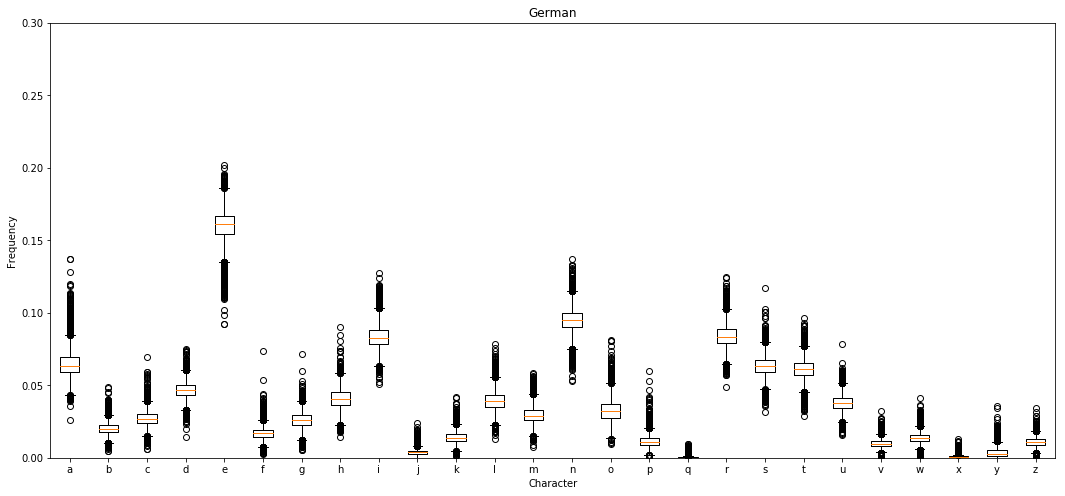

In [8]:
mean_de, std_de, dist_de = load_np_distribution('mean_de.npy', 'std_de.npy', 'dist_de.npy', 
                                                lambda: character_distribution(people_de['text']))
box_plot(dist_de, 'German')

np.save('mean.de.npy', mean_de)
np.save('std_de.npy', std_de)
np.save('dist_de', dist_de) 

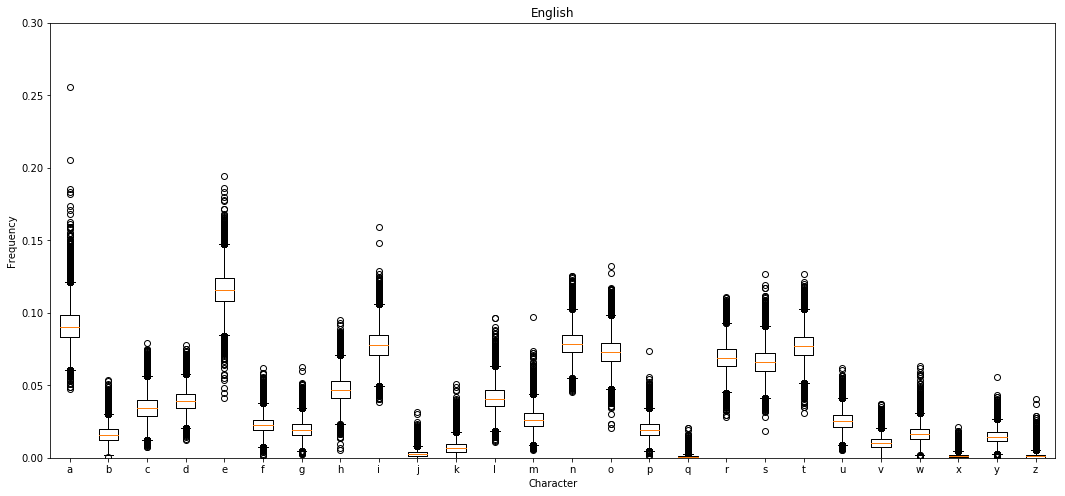

In [9]:
mean_en, std_en, dist_en = load_np_distribution('mean_en.npy', 'std_en.npy', 'dist_en.npy', 
                                                lambda: character_distribution(people_en['text']))
# mean_en, std_en, dist_en = character_distribution(people_en['text'])
box_plot(dist_en, 'English')

np.save('mean_en.npy', mean_en)
np.save('std_en.npy', std_en)
np.save('dist_en.npy', dist_en)

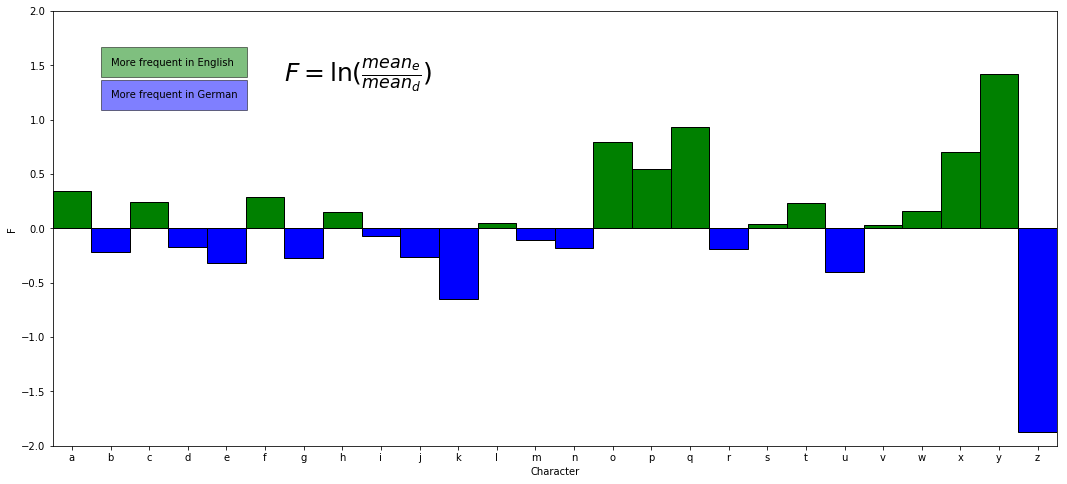

In [10]:
frequency_plot(mean_en, mean_de)

## Spracherkennung

In [11]:
def calc_p(mean: np.ndarray, std: np.ndarray, dist: np.ndarray) -> float:
    #p = stats.norm.logpdf(dist, mean, std)
    p = np.log(stats.norm.pdf(dist, mean, std) + 1e-7)
    return p.sum()


def plot_p(p_de: [float], p_en: [float], epsilon: float):
    fig, ax = plt.subplots(figsize = (18, 8))
    ind = np.arange(len(p_de))
    width = 1
    
    rects1 = ax.bar(ind, p_de, width, color = 'blue', alpha=0.6)
    rects2 = ax.bar(ind, p_en, width, color = 'green', alpha=0.6)
    line = ax.plot(ind, np.full((len(p_de)), epsilon), 'y--')
    ax.set_xlabel('Texts')
    ax.set_ylabel('P')
    plt.legend([rects1, rects2], ['German', 'English'])
    plt.title("P distribution")
    plt.show()
    
    
class language_detector:
    def __init__(self,
                 mean_de: np.ndarray, 
                 std_de: np.ndarray, 
                 mean_en: np.ndarray, 
                 std_en: np.ndarray,
                 epsilon: float = 10,
                 mean_freq_threshold: float = 0.5,
                 mask: np.ndarray = None):
        self.mean_de = mean_de
        self.std_de = std_de
        self.mean_en = mean_en
        self.std_en = std_en
        self.epsilon = epsilon
        self.mean_freq_threshold = mean_freq_threshold
        self.lang = []
        self.p_des = []
        self.p_ens = []
        self.mask = mask
    
    def determine_language(self, texts: [str]):
        del self.lang[:]
        del self.p_des[:]
        del self.p_ens[:]
        
        dist = np.zeros(shape=26)

        mean_freq = np.abs(self.mean_de / self.mean_en - 1)
        freq_bool = mean_freq > self.mean_freq_threshold
        freq_bool = self.mask
        
        freq_bool = self.__find_best_letters()

        for i in range(texts.shape[0]):
            fdist = nltk.FreqDist(get_chars(texts[i]))

            dist[:] = [fdist.freq(c) for c in get_letters()]

            p_de = calc_p(mean_de[freq_bool], std_de[freq_bool], dist[freq_bool])
            p_en = calc_p(mean_en[freq_bool], std_en[freq_bool], dist[freq_bool])

            self.p_des.append(p_de)
            self.p_ens.append(p_en)

            if p_de > p_en and p_de > epsilon:
                self.lang.append('G')
            elif p_en > p_de and p_en > epsilon:
                self.lang.append('E')
            else:
                self.lang.append('X')
    
    def __find_best_letters(self):
        b1 = self.std_de < 0.01
        b2 = self.std_en < 0.01
        mean_freq = np.abs(self.mean_de / self.mean_en-1)
        freq_bool = mean_freq > self.mean_freq_threshold
        b3 = np.bitwise_and(b1, b2)
        b4 = np.bitwise_and(b3, freq_bool)

        letters = np.array(get_letters())
        print("used letter: ", letters[b4])
        return b4
    
    def plot_p_distribution(self):
        plot_p(self.p_des, self.p_ens, self.epsilon)
        
    def cm(self, true_labels):
        cm = confusion_matrix(true_labels, self.lang)
        plot_confusion_matrix(cm, ['English', 'German', 'X'])
        return cm
    
    def print_accuracy(self, cm):
        print('Accuracy:', accuracy(cm))

In [12]:
def accuracy(cm):
    i = np.eye(cm.shape[0])
    return (i * cm).sum() / cm.sum()

In [13]:
people_test = pd.read_csv('Language_test.csv', sep=';', quotechar='|')
lang_true = np.array(people_test['language'])

epsilon = 1
mean_freq_threshold = 0.25
detector = language_detector(mean_de, std_de, mean_en, std_en, epsilon=epsilon, mean_freq_threshold=mean_freq_threshold)

## People Test ==========================================================

used letter:  ['f' 'g' 'j' 'k' 'o' 'p' 'q' 'u' 'x' 'y' 'z']


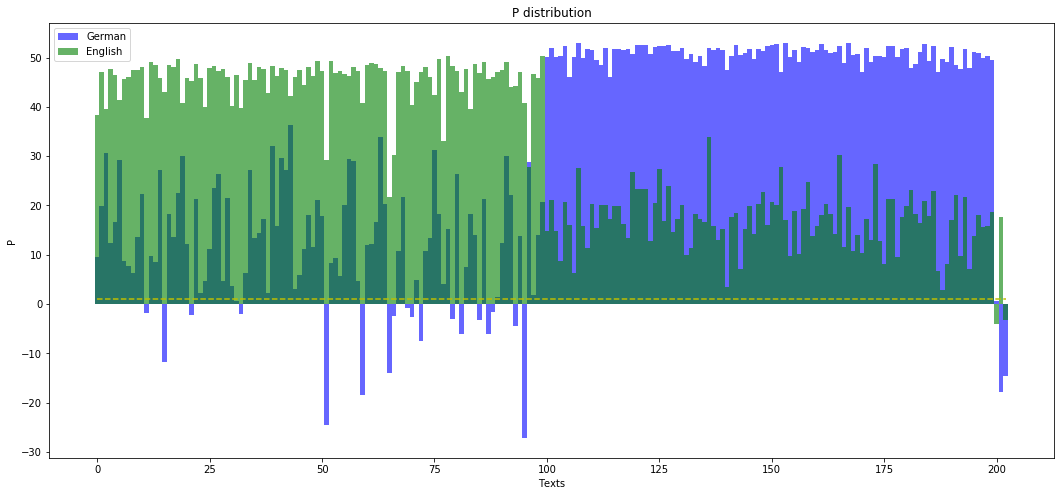

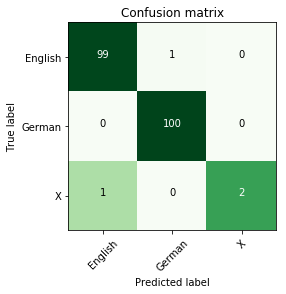

Accuracy: 0.9901477832512315


In [14]:
detector.determine_language(people_test['text'])
detector.plot_p_distribution()
cm = detector.cm(lang_true)
detector.print_accuracy(cm)

## People Test Splitt into train and val

used letter:  ['c' 'f' 'k' 'o' 'p' 'q' 't' 'u' 'x' 'y' 'z']


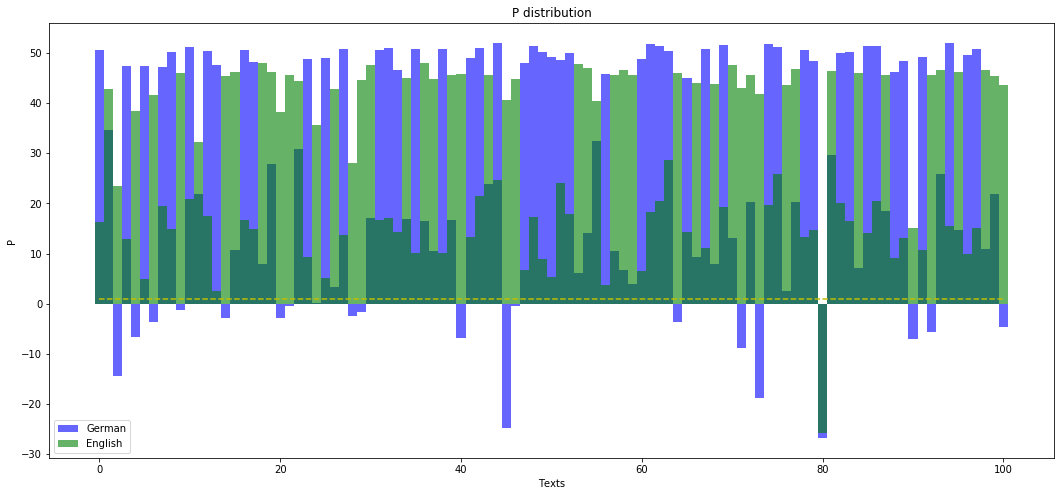

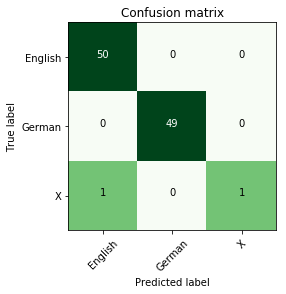

Accuracy: 0.9900990099009901


In [15]:
idx = np.arange(len(people_test['text']))
np.random.shuffle(idx)
n = len(idx)

ppl_test = np.array(people_test['text'])[idx]
lang_true2 = lang_true[idx]
split = n // 2

x_test = ppl_test[:split]
x_val = ppl_test[split+1:]

y_test = lang_true2[:split]
y_val = lang_true2[split+1:]


mean_en_test, std_en_test, dist_en_test = load_np_distribution('mean_en_test.npy', 'std_en_test.npy', 'dist_en_test.npy', 
                                                lambda: character_distribution(people_en['text']))

mean_de_test, std_de_test, dist_de_test = load_np_distribution('mean_de.npy', 'std_de.npy', 'dist_de.npy', 
                                                lambda: character_distribution(people_de['text']))

np.save('mean_en_test.npy', mean_en_test)
np.save('std_en_test.npy', std_en_test)
np.save('dist_en_test.npy', dist_en_test)

np.save('mean_de_test.npy', mean_de_test)
np.save('std_de_test.npy', std_de_test)
np.save('dist_de_test.npy', dist_de_test)

detector2 = language_detector(mean_en_test, std_en_test, mean_de_test, std_en_test, epsilon=epsilon, mean_freq_threshold=mean_freq_threshold)

detector2.determine_language(x_val)
detector2.plot_p_distribution()
cm = detector2.cm(y_val)
detector2.print_accuracy(cm)

## Old Newspaper

used letter:  ['f' 'g' 'j' 'k' 'o' 'p' 'q' 'u' 'x' 'y' 'z']


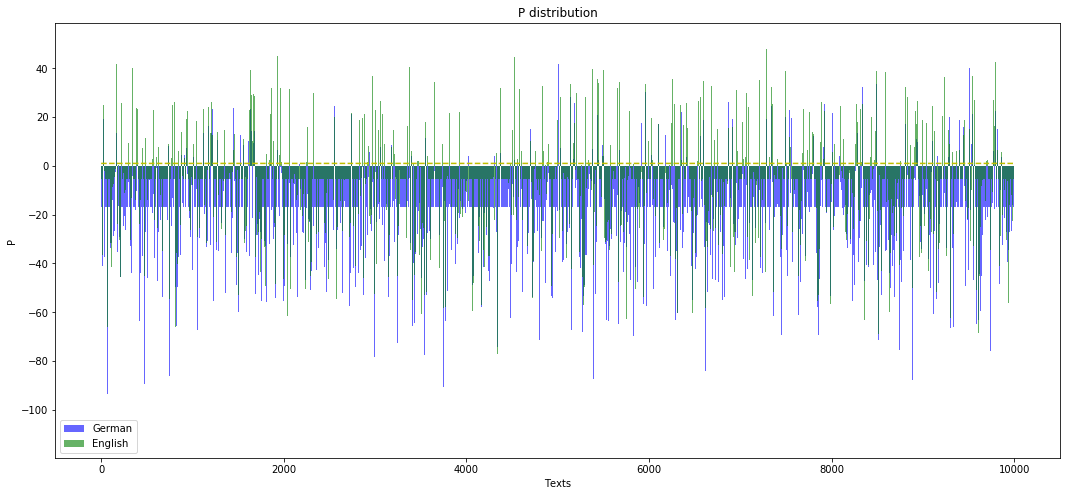

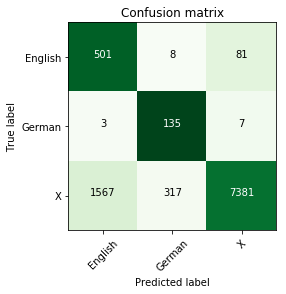

Accuracy: 0.8017


In [16]:
old_newspaper = np.load('old_newpaper.npy')
old_newspaper_true = old_newspaper[:, 0]

detector.determine_language(old_newspaper[:, 1])
detector.plot_p_distribution()
cm = detector.cm(old_newspaper_true)
detector.print_accuracy(cm)

## Kommentare aus Zeitung von Östereich

used letter:  ['f' 'g' 'j' 'k' 'o' 'p' 'q' 'u' 'x' 'y' 'z']


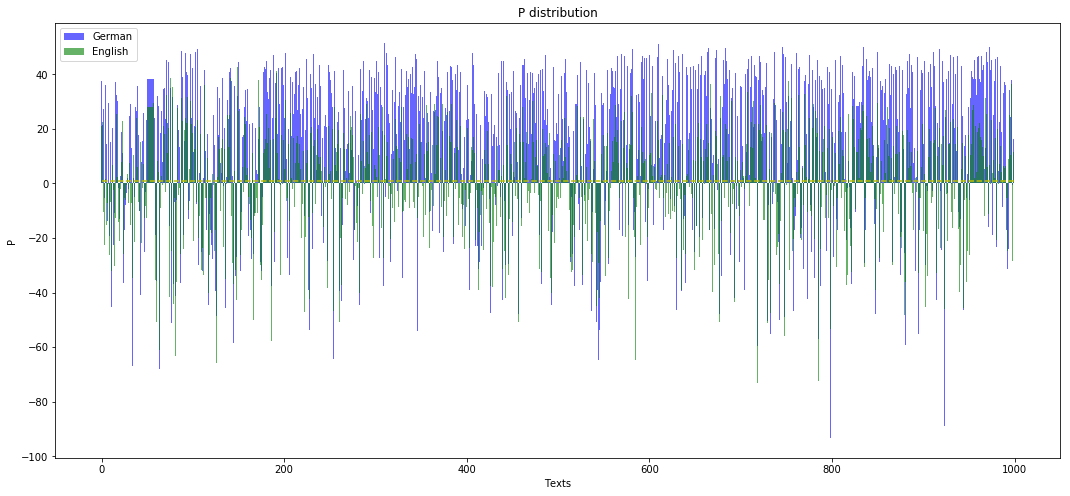

C:\Users\tobia\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


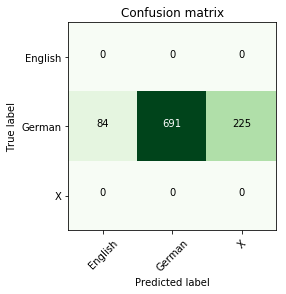

Accuracy: 0.691


In [17]:
people_test_german_only = np.load('german_only.npy')
lang_true_german_only = people_test_german_only[:, 0]

detector.determine_language(people_test_german_only[:, 1])
detector.plot_p_distribution()
cm = detector.cm(lang_true_german_only)
detector.print_accuracy(cm)

## Neural Network

### Preprocessing

In [18]:
import keras
import re

def character_distribution_nn(people: [str]) -> np.ndarray:
    x = np.zeros(shape=(len(people), 26))
    
    for i, text in enumerate(people):
        fdist = nltk.FreqDist(get_chars(text))        
        x[i, :] = [fdist.freq(c) for c in get_letters()]
    return x

C:\Users\tobia\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [19]:
x_de = load_np('x_de.npy', lambda: character_distribution_nn(people_de['text']))

In [20]:
x_en = load_np('x_en.npy', lambda: character_distribution_nn(people_en['text']))

In [21]:
x_train = np.vstack((x_de, x_en))
y_train = np.vstack((np.zeros(shape=(x_de.shape[0], 1)), np.ones(shape=(x_en.shape[0], 1))))

rand = np.random.permutation(x_train.shape[0])
x_train = x_train[rand]
y_train = y_train[rand]

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)

x_train:  (69071, 26)
y_train:  (69071, 1)


### Training

Train on 55256 samples, validate on 13815 samples
Epoch 1/7
 - 10s - loss: 0.4220 - acc: 0.8557 - val_loss: 0.4056 - val_acc: 0.8530
Epoch 2/7
 - 6s - loss: 0.3904 - acc: 0.8558 - val_loss: 0.3737 - val_acc: 0.8530
Epoch 3/7
 - 6s - loss: 0.3288 - acc: 0.8558 - val_loss: 0.2577 - val_acc: 0.8530
Epoch 4/7
 - 6s - loss: 0.1583 - acc: 0.9364 - val_loss: 0.0727 - val_acc: 0.9891
Epoch 5/7
 - 6s - loss: 0.0484 - acc: 0.9949 - val_loss: 0.0252 - val_acc: 0.9978
Epoch 6/7
 - 7s - loss: 0.0232 - acc: 0.9975 - val_loss: 0.0155 - val_acc: 0.9986
Epoch 7/7
 - 7s - loss: 0.0154 - acc: 0.9979 - val_loss: 0.0102 - val_acc: 0.9986
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


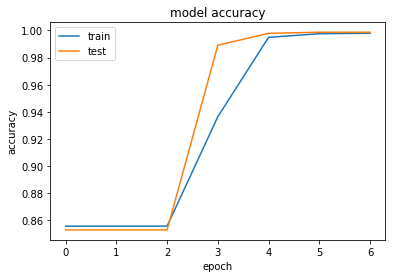

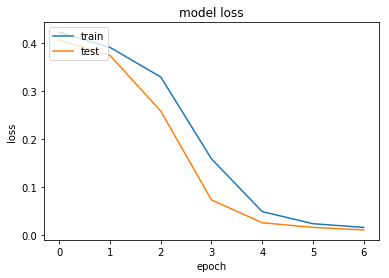

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

y_binary = to_categorical(y_train)
model = Sequential()

model.add(Dense(units=120, input_dim=26))
model.add(Dropout(0.2))
model.add(Dense(units=240, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=240, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=2, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

history = model.fit(x_train, y_binary, epochs=7, batch_size=50, verbose=2, validation_split=0.2)

print(history.history.keys())

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Prediction

In [23]:
def determine_language_nn(texts: [str]) -> [str]:
    lang = []
    ps = []
    
    for k, text in enumerate(texts):
        x_data = np.zeros(shape=(1, 26))
        fdist = nltk.FreqDist(get_chars(text))
        x_data[0, :] = [fdist.freq(c) for c in get_letters()]
        p = model.predict(x_data)
        ps.append(p)
        
        if p[0, 0] > 0.95:
            lang.append('G')
        elif p[0, 1] > 0.95:
            lang.append('E')
        else:
            lang.append('X')
            
    return lang

## People Test mit Neural Network mit Neural Network

Accuracy: 0.9852216748768473


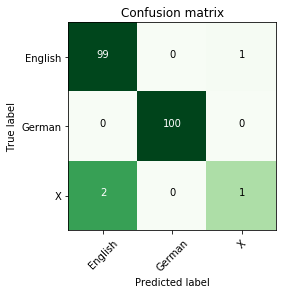

In [24]:
lang = determine_language_nn(people_test['text'])
cm = confusion_matrix(lang_true, lang)
print('Accuracy:', accuracy(cm))
plot_confusion_matrix(cm, ['English', 'German', 'X'])

## Kommentare aus Zeitung von Östereich mit Neural Network

Accuracy: 0.649


C:\Users\tobia\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


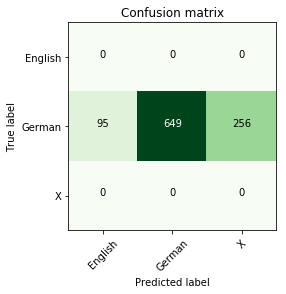

In [25]:
people_test_german_only = np.load('german_only.npy')

lang = determine_language_nn(people_test_german_only[:, 1])
lang_true_german_only = people_test_german_only[:, 0]
cm = confusion_matrix(lang_true_german_only, lang)
print('Accuracy:', accuracy(cm))
plot_confusion_matrix(cm, ['English', 'German', 'X'])

## Elon Musk Twitter Tweets mit Neural Network

Accuracy: 0.882224984462399


C:\Users\tobia\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


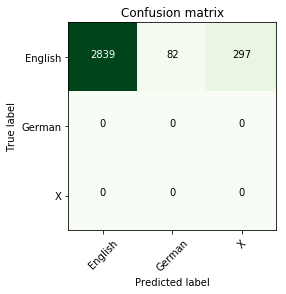

In [26]:
elonmusk_tweets = np.load('elonmusk_tweets.npy')

lang = determine_language_nn(elonmusk_tweets[:, 1])
lang_true_german_only = elonmusk_tweets[:, 0]
cm = confusion_matrix(lang_true_german_only, lang)
print('Accuracy:', accuracy(cm))
plot_confusion_matrix(cm, ['English', 'German', 'X'])